In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler

# Setup
num_iterations = 10
row = 1000
np.random.seed(42)

# Lists to store the precision scores across iterations
bod_precisions = []
top_k_precisions = []
skyline_precisions = []
k_dominance_precisions = []
pareto_precisions = []

# Run the experiment n times
for _ in range(num_iterations):
    # Generate random data for location, house, and policy features
    location_data = pd.DataFrame({
        'near_urban': np.random.rand(row),      # Higher is better
        'crime_free': np.random.rand(row),      # Higher is better
        'view': np.random.rand(row)             # Higher is better
    })

    house_data = pd.DataFrame({
        'size': np.random.rand(row),            # Higher is better
        'age': np.random.rand(row),
        'style': np.random.rand(row)
    })

    policy_data = pd.DataFrame({
        'policy': np.random.rand(row),          # Higher is better
        'tax': np.random.rand(row),
        'growth': np.random.rand(row)
    })

    # Combine the dataframes
    combined_data = pd.concat([location_data, house_data, policy_data], axis=1)

    # Normalize the data
    scaler = MinMaxScaler()
    combined_data_normalized = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

    # Calculate the housing price based on the new criteria (this serves as our target variable)
    housing_prices = (
        1/3 * combined_data_normalized['near_urban'] +
        1.0 * combined_data_normalized['crime_free'] +
        2/3 * combined_data_normalized['view'] +
        1/3 * combined_data_normalized['size'] -
        2/3 * combined_data_normalized['age'] +
        1.0 * combined_data_normalized['style'] +
        1.0 * combined_data_normalized['policy'] -
        1/3 * combined_data_normalized['tax'] +
        2/3 * combined_data_normalized['growth'] +
        np.random.normal(scale=0.1, size=row)  # Adding some random noise
    )

    # Assume true labels based on a threshold housing price (dummy example for comparison)
    true_labels = (housing_prices > housing_prices.median()).astype(int)

    ################################### BOD Implementation ###################################
    def bod_algorithm(data):
        selected_columns_1 = data[['crime_free', 'style', 'policy']]
        y_min_1 = selected_columns_1.sum(axis=1).quantile(0.75)  # Using Q3 as a dynamic threshold
        y_max_1 = data.loc[selected_columns_1.sum(axis=1).idxmax()].sum()

        return_index_list_1 = [
            idx for idx, i in enumerate(data.sum(axis=1))
            if y_min_1 <= i <= y_max_1
        ]
        filter_1st_dataframe = data.iloc[return_index_list_1].copy()

        selected_columns_2 = filter_1st_dataframe[['crime_free', 'style', 'policy', 'view', 'age', 'growth']]
        y_min_2 = selected_columns_2.sum(axis=1).quantile(0.75)
        y_max_2 = filter_1st_dataframe.loc[selected_columns_2.sum(axis=1).idxmax()].sum()

        return_index_list_2 = [
            idx for idx, i in enumerate(filter_1st_dataframe.sum(axis=1))
            if y_min_2 <= i <= y_max_2
        ]
        filter_2nd_theFinal_dataframe = filter_1st_dataframe.iloc[return_index_list_2].copy()

        selected_columns_3 = filter_2nd_theFinal_dataframe
        y_min_3 = selected_columns_3.sum(axis=1).quantile(0.75)
        y_max_3 = filter_2nd_theFinal_dataframe.loc[selected_columns_3.sum(axis=1).idxmax()].sum()

        return_index_list_3 = [
            idx for idx, i in enumerate(filter_2nd_theFinal_dataframe.sum(axis=1))
            if y_min_3 <= i <= y_max_3
        ]

        bod_selection = filter_2nd_theFinal_dataframe.iloc[return_index_list_3]
        return bod_selection

    ################################### Unsupervised Top-k Algorithm ###################################
    def unsupervised_top_k_algorithm(data, k=10):
        data['score'] = data.sum(axis=1)
        top_k_selection = data.nlargest(k, 'score')
        return top_k_selection

    ################################### Alternative Skyline Algorithm ###################################
    def alternative_skyline_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        skyline_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            dominated = False
            for j in range(len(skyline_set)):
                if dominates(skyline_set[j], row):
                    dominated = True
                    break
                if dominates(row, skyline_set[j]):
                    skyline_set[j] = row
                    dominated = True
                    break
            if not dominated:
                skyline_set.append(row)

        skyline_df = pd.DataFrame(skyline_set)
        return skyline_df

    ################################### K-Dominance Algorithm ###################################
    def k_dominance_algorithm(data, k=3):
        def k_dominates(row, other_row, k):
            dominance_count = sum(row > other_row)
            return dominance_count >= k

        k_dominant_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            if not any(k_dominates(other_row, row, k) for other_row in data.values):
                k_dominant_set.append(row)

        k_dominant_df = pd.DataFrame(k_dominant_set)
        return k_dominant_df

    ################################### Pareto Optimality Algorithm ###################################
    def pareto_optimal_algorithm(data):
        def dominates(row, other_row):
            return all(row >= other_row) and any(row > other_row)

        pareto_set = []
        for i in range(len(data)):
            row = data.iloc[i]
            if not any(dominates(other_row, row) for other_row in data.values):
                pareto_set.append(row)

        pareto_df = pd.DataFrame(pareto_set)
        return pareto_df

    ################################### Precision Comparison ###################################
    # BOD Precision
    bod_selection = bod_algorithm(combined_data_normalized)
    bod_precision = precision_score(true_labels[:len(bod_selection)], np.ones(len(bod_selection)), average='binary', zero_division=0)
    bod_precisions.append(bod_precision)

    # Unsupervised Top-k Precision
    top_k_selection = unsupervised_top_k_algorithm(combined_data_normalized, k=10)
    top_k_precision = precision_score(true_labels[:len(top_k_selection)], np.ones(len(top_k_selection)), average='binary', zero_division=0)
    top_k_precisions.append(top_k_precision)

    # Alternative Skyline Precision
    skyline_selection = alternative_skyline_algorithm(combined_data_normalized)
    skyline_precision = precision_score(true_labels[:len(skyline_selection)], np.ones(len(skyline_selection)), average='binary', zero_division=0)
    skyline_precisions.append(skyline_precision)

    # K-Dominance Precision
    k_dominance_selection = k_dominance_algorithm(combined_data_normalized, k=3)
    k_dominance_precision = precision_score(true_labels[:len(k_dominance_selection)], np.ones(len(k_dominance_selection)), average='binary', zero_division=0)
    k_dominance_precisions.append(k_dominance_precision)

    # Pareto Optimality Precision
    pareto_selection = pareto_optimal_algorithm(combined_data_normalized)
    pareto_precision = precision_score(true_labels[:len(pareto_selection)], np.ones(len(pareto_selection)), average='binary', zero_division=0)
    pareto_precisions.append(pareto_precision)

# Calculate the average precision for each algorithm
avg_bod_precision = np.mean(bod_precisions)
avg_top_k_precision = np.mean(top_k_precisions)
avg_skyline_precision = np.mean(skyline_precisions)
avg_k_dominance_precision = np.mean(k_dominance_precisions)
avg_pareto_precision = np.mean(pareto_precisions)

# Print all average precision results
print(f"Average BOD Precision: {avg_bod_precision}")
print(f"Average Top-K Precision: {avg_top_k_precision}")
print(f"Average Skyline Precision: {avg_skyline_precision}")
print(f"Average K-Dominance Precision: {avg_k_dominance_precision}")
print(f"Average Pareto Optimality Precision: {avg_pareto_precision}")



Average BOD Precision: 0.5034317177799628
Average Top-K Precision: 0.45000000000000007
Average Skyline Precision: 0.5003002161220513
Average K-Dominance Precision: 0.0
Average Pareto Optimality Precision: 0.5026493435969679


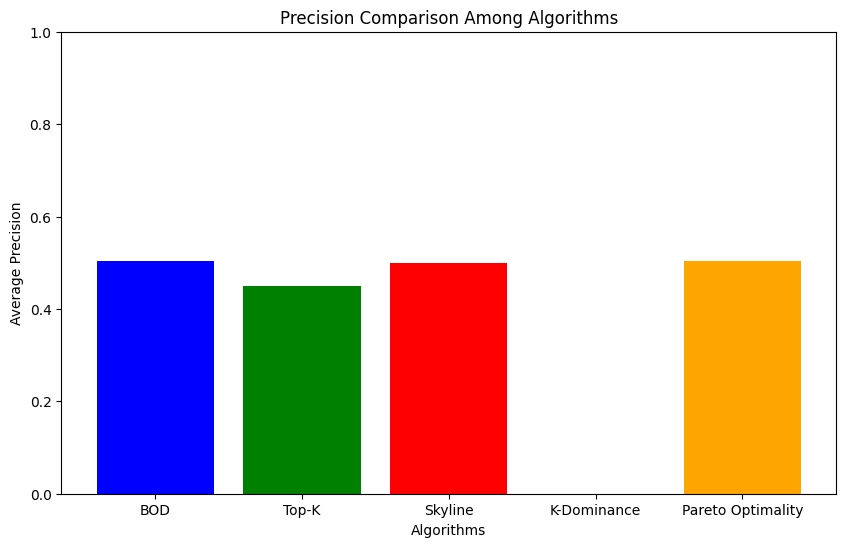

In [ ]:
import matplotlib.pyplot as plt

# Data for the chart
labels = ['BOD', 'Top-K', 'Skyline', 'K-Dominance', 'Pareto Optimality']
precisions = [avg_bod_precision, avg_top_k_precision, avg_skyline_precision, avg_k_dominance_precision, avg_pareto_precision]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, precisions, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add title and labels
plt.title('Precision Comparison Among Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Average Precision')

# Display the chart
plt.ylim(0, 1)
plt.show()
